In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [44]:
data = pd.read_csv('TelcoCustomerChurn.csv')
data.head()

data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [45]:
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [127]:
data['TotalCharges'] = data['TotalCharges'].replace(" " , np.nan)
data = data[data['TotalCharges'].notnull()]
data = data.reset_index()[data.columns]

data['TotalCharges']  = data['TotalCharges'].astype(float)

# Relacing no internate service by no

Replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in Replace :
    data[i]  = data[i].replace({'No internate Service' : 'No'})
    
data['MultipleLines'] = data['MultipleLines'].replace({'MultipleLines' : 'No'})

def tenure_lab(data) :
    
    if data["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (data["tenure"] > 12) & (data["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (data["tenure"] > 24) & (data["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (data["tenure"] > 48) & (data["tenure"] <= 60) :
        return "Tenure_48-60"
    elif data["tenure"] > 60 :
        return "Tenure_gt_60"
    
data["tenure_group"] = data.apply(lambda data:tenure_lab(data), axis = 1)

data['tenure_group'].value_counts()



Tenure_0-12     2175
Tenure_24-48    1594
Tenure_gt_60    1407
Tenure_12-24    1024
Tenure_48-60     832
Name: tenure_group, dtype: int64

In [47]:
# Seperating Churn Data 

Churn = data[data['Churn'] == 'Yes']
Nourn = data[data['Churn'] == 'No']


Text(0.5, 1.0, 'Churn = Yes Vs Tenure')

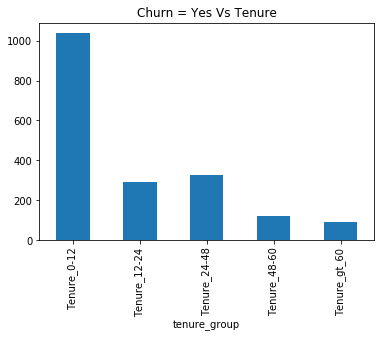

In [48]:
# Data Exploration 

TenureChurn = Churn.groupby('tenure_group').size()
TenureChurn.plot(kind = 'bar')
plt.title('Churn = Yes Vs Tenure')

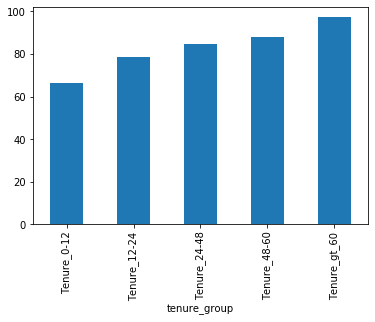

In [65]:
Avg = Churn.groupby(['tenure_group'])['MonthlyCharges'].mean()
Avg.plot(kind ='bar')

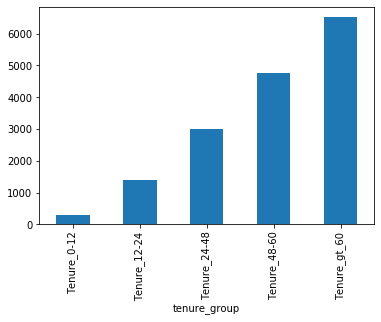

In [66]:
Avg = Churn.groupby(['tenure_group'])['TotalCharges'].mean()
Avg.plot(kind ='bar')

In [133]:
# Data Preprocessing 

Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = data.nunique()[data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
binary_col = data.nunique()[data.nunique() == 2].keys().tolist()
multiple_col = multi_cols = [i for i in cat_cols if i not in binary_col]

cols = [x for x in data.columns if x not in Id_col + target_col ]

from sklearn.model_selection import train_test_split 

train,test = train_test_split(data,test_size = .25 ,random_state = 111)

train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

# lebal encoding for the binary variables

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for i in binary_col:
    data[i] = encoder.fit_transform(data[i])

# Dummy variabel coding

data = pd.get_dummies(data= data, columns = multiple_col)

# Scaling the numerical values 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled = scaler.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns

data_processed = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")





In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
import seaborn as sns

In [135]:
lr =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

    accuracy                           0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.800910125142207


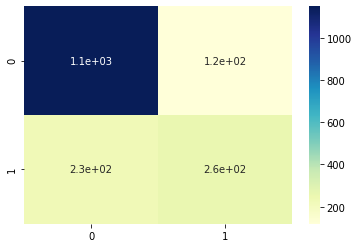

In [165]:
# Fitting a model

lr.fit(train_X,train_Y)
predictions =  lr.predict(test_X)
probabilities = lr.predict_proba(test_X)

coeff = pd.DataFrame(lr.coef_.ravel())
columns = pd.DataFrame(cols)
coef_summary = (pd.merge(coeff,columns,left_index= True, right_index= True, how = "left"))
coef_summary.columns = ["coeff","features"]
coef_summary    = coef_summary.sort_values(by = "coeff",ascending = False)
coef_summary     = coef_summary.iloc[:5]
print(lr)

print ("\n Classification report : \n",classification_report(test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(test_Y,predictions))


# COnfusion Matrix

matrix = confusion_matrix(test_Y,predictions)

# plotting confusion matrix

sns.heatmap(matrix,cmap="YlGnBu", annot= True)

plt.show()



Area under curve :  0.717361424064894 



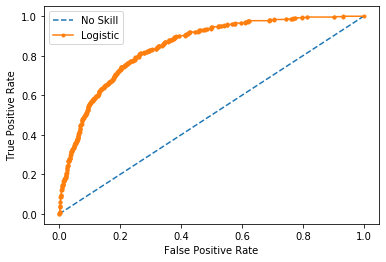

In [154]:
# ROC_AUC_SCORE

roc_auc = roc_auc_score(test_Y,predictions)
print ("Area under curve : ",roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_Y))]
ns_auc = roc_auc_score(test_Y, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(test_Y, ns_probs)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

,coeff,features
33,0.619725,Contract_Month-to-month
6,0.368347,PaperlessBilling
43,0.348757,tenure_group_Tenure_48-60
13,0.342597,InternetService_Fiber optic
1,0.216203,SeniorCitizen


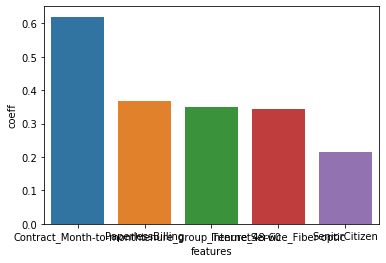

In [167]:
#plotting the co efficients

ax = sns.barplot(x = coef_summary['features'], y= coef_summary['coeff'],)
coef_summary
